In [1]:
# ============================================================
# 🚀 PyTorch + PyG + Numpy (torch==2.2.0）
# ============================================================
# if you meet problem to run this envuronment, please restart your runtime.

import os
import torch
from IPython.display import clear_output

print("Uninstalling conflicting packages...")
os.system("pip uninstall -y torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib numpy")

# ------------------------------------------------------------
# 1) numpy（
# ------------------------------------------------------------
print("Installing numpy==1.26.4 ...")
os.system("pip install numpy==1.26.4 -q")

# ------------------------------------------------------------
# 2) Torch 2.2.0（
# ------------------------------------------------------------
print("Installing torch==2.2.0 ...")
os.system("pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 -q")

clear_output()
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda if torch.cuda.is_available() else "CPU-only")

# ------------------------------------------------------------
# 3) PyG（
# ------------------------------------------------------------
if torch.cuda.is_available():
    print("Installing PyG for CUDA...")
    #  Colab GPU = CUDA 12.1
    pyg_url = "https://data.pyg.org/whl/torch-2.2.0+cu121.html"
else:
    print("Installing PyG for CPU...")
    pyg_url = "https://data.pyg.org/whl/torch-2.2.0+cpu.html"

cmd = f"pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f {pyg_url}"
print("Running:", cmd)
os.system(cmd)

clear_output()

# ------------------------------------------------------------
# 4) validation
# ------------------------------------------------------------
import torch
import numpy as np
import torch_geometric

print("🎉 Initialization Complete!")
print("Torch:", torch.__version__)
print("Numpy:", np.__version__)
print("PyG:", torch_geometric.__version__)
print("CUDA:", torch.cuda.is_available())
print("Ready for Heterogeneous GNN 🚀")


🎉 Initialization Complete!
Torch: 2.2.0+cu121
Numpy: 1.26.4
PyG: 2.7.0
CUDA: False
Ready for Heterogeneous GNN 🚀


In [2]:
# !pip uninstall -y numpy
# !pip install numpy==1.26.4
# !pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 -q
import kagglehub
import pandas as pd
import numpy as np
import torch
import ast

dataset_path = kagglehub.dataset_download("tmdb/tmdb-movie-metadata")

df_movies  = pd.read_csv(dataset_path + "/tmdb_5000_movies.csv")
df_credits = pd.read_csv(dataset_path + "/tmdb_5000_credits.csv")

df_movies.head(), df_credits.head()


Using Colab cache for faster access to the 'tmdb-movie-metadata' dataset.


(      budget                                             genres  \
 0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
 1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
 2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
 3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
 4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
 
                                        homepage      id  \
 0                   http://www.avatarmovie.com/   19995   
 1  http://disney.go.com/disneypictures/pirates/     285   
 2   http://www.sonypictures.com/movies/spectre/  206647   
 3            http://www.thedarkknightrises.com/   49026   
 4          http://movies.disney.com/john-carter   49529   
 
                                             keywords original_language  \
 0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
 1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
 2 

In [3]:

def parse_genres(x):
    # already a python list
    if isinstance(x, list):
        return x

    # if it's empty or invalid
    if pd.isna(x) or x == "":
        return []

    # otherwise parse the JSON string
    try:
        return [d["name"] for d in ast.literal_eval(x)]
    except:
        # fallback for JSON with double quotes
        import json
        return [d["name"] for d in json.loads(x)]


df_movies["genres"] = df_movies["genres"].apply(parse_genres)


# 合并两个 df
df = df_movies.merge(df_credits, left_on="id", right_on="movie_id")

# 解析 cast
df["cast"] = df["cast"].apply(
    lambda x: [c["name"] for c in ast.literal_eval(x)[:5]]
)

# 解析 crew，找到导演
df["crew"] = df["crew"].apply(lambda x: ast.literal_eval(x))
df["director"] = df["crew"].apply(
    lambda crew: next((c["name"] for c in crew if c["job"] == "Director"), None)
)

print(df.head())


      budget                                         genres  \
0  237000000  [Action, Adventure, Fantasy, Science Fiction]   
1  300000000                   [Adventure, Fantasy, Action]   
2  245000000                     [Action, Adventure, Crime]   
3  250000000               [Action, Crime, Drama, Thriller]   
4  260000000           [Action, Adventure, Science Fiction]   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, 

In [4]:
# drop meannless features

df = df[[
    "id",
    "title_x",
    "budget",
    "popularity",
    "runtime",
    "vote_average",
    "vote_count",
    "revenue",
    "genres",
    "cast",
    "director",
]]

df = df.rename(columns={"title_x": "title"})

df.head()


,id,title,budget,popularity,runtime,vote_average,vote_count,revenue,genres,cast,director
0,19995,Avatar,237000000,150.437577,162.0,7.2,11800,2787965087,"[Action, Adventure, Fantasy, Science Fiction]","[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron
1,285,Pirates of the Caribbean: At World's End,300000000,139.082615,169.0,6.9,4500,961000000,"[Adventure, Fantasy, Action]","[Johnny Depp, Orlando Bloom, Keira Knightley, ...",Gore Verbinski
2,206647,Spectre,245000000,107.376788,148.0,6.3,4466,880674609,"[Action, Adventure, Crime]","[Daniel Craig, Christoph Waltz, Léa Seydoux, R...",Sam Mendes
3,49026,The Dark Knight Rises,250000000,112.312950,165.0,7.6,9106,1084939099,"[Action, Crime, Drama, Thriller]","[Christian Bale, Michael Caine, Gary Oldman, A...",Christopher Nolan
4,49529,John Carter,260000000,43.926995,132.0,6.1,2124,284139100,"[Action, Adventure, Science Fiction]","[Taylor Kitsch, Lynn Collins, Samantha Morton,...",Andrew Stanton


In [5]:
# ===== 1. data cleaning =====

# 1) runtime
df["runtime"] = df["runtime"].fillna(0)

# 2) budget：
df["budget"] = df["budget"].fillna(0)

# log transform（
df["budget_log"] = np.log1p(df["budget"])
df["budget_log"] = df["budget_log"].replace([np.inf, -np.inf], 0).fillna(0)

df["revenue"] = df["revenue"].fillna(0)
df["revenue_log"] = np.log1p(df["revenue"])
df["revenue_log"] = df["revenue_log"].replace([np.inf, -np.inf], 0).fillna(0)

# 3) director
df["director"] = df["director"].fillna("UnknownDirector")


# ===== 2. 特征 ROI 处理 =====

# ROI = revenue / budget
df["roi"] = df["revenue"] / df["budget"].replace(0, np.nan)
df["roi"] = df["roi"].replace([np.inf, -np.inf], 0).fillna(0)


# ===== 3. Success label =====

#  ROI
df["success"] = (df["roi"] > 1.0).astype(int)

# revenue = > 0 ：vote_count + vote_average
df.loc[df["revenue"] == 0, "success"] = (
    (df["vote_count"] > 200) &
    (df["vote_average"] > 7.0)
).astype(int)


# ===== 4. check NaN / Inf =====

print("budget_log NaN:", df["budget_log"].isna().sum())
print("revenue_log NaN:", df["revenue_log"].isna().sum())
print("roi NaN:", df["roi"].isna().sum())
print("runtime NaN:", df["runtime"].isna().sum())



budget_log NaN: 0
revenue_log NaN: 0
roi NaN: 0
runtime NaN: 0


In [6]:


# ----- features -----
movie_feature_cols = [
    "popularity",
    "runtime",
    "vote_average",
    "vote_count",
    "budget_log",
    "roi"
]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

movie_features = scaler.fit_transform(df[movie_feature_cols])
x_movie = torch.tensor(movie_features, dtype=torch.float)

# ----- label -----
y_success = torch.tensor(df["success"].values, dtype=torch.long)
y_revenue = torch.tensor(df["revenue_log"].values, dtype=torch.float)

num_movies = len(df)
print("num_movies:", num_movies)

num_movies: 4803


In [7]:
# ---- movie node -> index 映射 ----
movie_id_to_index = {mid: i for i, mid in enumerate(df["id"].values)}

# ---- Actor ----
all_actors = sorted({name for cast_list in df["cast"] for name in cast_list})
actor_name_to_index = {name: i for i, name in enumerate(all_actors)}
num_actors = len(all_actors)
print("num_actors:", num_actors)

# ---- Director ----
all_directors = sorted(df["director"].dropna().unique().tolist())
director_name_to_index = {name: i for i, name in enumerate(all_directors)}
num_directors = len(all_directors)
print("num_directors:", num_directors)

# ---- Genre ----
all_genres = sorted({g for g_list in df["genres"] for g in g_list})
genre_name_to_index = {g: i for i, g in enumerate(all_genres)}
num_genres = len(all_genres)
print("num_genres:", num_genres)


num_actors: 9390
num_directors: 2350
num_genres: 20


In [8]:
from torch_geometric.data import HeteroData

data = HeteroData()

# movie nodes
data["movie"].x = x_movie
data["movie"].y_success = y_success
data["movie"].y_revenue = y_revenue
revenue_mask = (df["revenue"] > 0).values
data["movie"].revenue_mask = torch.tensor(revenue_mask, dtype=torch.bool)
#  embedding
data["actor"].num_nodes = num_actors
data["director"].num_nodes = num_directors
data["genre"].num_nodes = num_genres

# -------- build edge --------
movie_actor_src, movie_actor_dst = [], []
movie_director_src, movie_director_dst = [], []
movie_genre_src, movie_genre_dst = [], []

for row_idx, row in df.iterrows():
    m_idx = row_idx

    # actors
    for actor in row["cast"]:
        a_idx = actor_name_to_index[actor]
        movie_actor_src.append(m_idx)
        movie_actor_dst.append(a_idx)

    # director
    d_idx = director_name_to_index[row["director"]]
    movie_director_src.append(m_idx)
    movie_director_dst.append(d_idx)

    # genres
    for g in row["genres"]:
        g_idx = genre_name_to_index[g]
        movie_genre_src.append(m_idx)
        movie_genre_dst.append(g_idx)

import torch

# movie → actor   and actor → movie
data["movie", "acted_in", "actor"].edge_index = torch.tensor(
    [movie_actor_src, movie_actor_dst], dtype=torch.long
)
data["actor", "acted_by", "movie"].edge_index = torch.tensor(
    [movie_actor_dst, movie_actor_src], dtype=torch.long
)

# movie → director
data["movie", "directed_by", "director"].edge_index = torch.tensor(
    [movie_director_src, movie_director_dst], dtype=torch.long
)
data["director", "directs", "movie"].edge_index = torch.tensor(
    [movie_director_dst, movie_director_src], dtype=torch.long
)

# movie → genre
data["movie", "has_genre", "genre"].edge_index = torch.tensor(
    [movie_genre_src, movie_genre_dst], dtype=torch.long
)
data["genre", "in_genre", "movie"].edge_index = torch.tensor(
    [movie_genre_dst, movie_genre_src], dtype=torch.long
)

print(data)


HeteroData(
  movie={
    x=[4803, 6],
    y_success=[4803],
    y_revenue=[4803],
    revenue_mask=[4803],
  },
  actor={ num_nodes=9390 },
  director={ num_nodes=2350 },
  genre={ num_nodes=20 },
  (movie, acted_in, actor)={ edge_index=[2, 23594] },
  (actor, acted_by, movie)={ edge_index=[2, 23594] },
  (movie, directed_by, director)={ edge_index=[2, 4803] },
  (director, directs, movie)={ edge_index=[2, 4803] },
  (movie, has_genre, genre)={ edge_index=[2, 12160] },
  (genre, in_genre, movie)={ edge_index=[2, 12160] }
)


In [9]:
from sklearn.model_selection import train_test_split

num_movies = data["movie"].num_nodes
all_idx = np.arange(num_movies)

train_idx, test_idx = train_test_split(all_idx, test_size=0.2, stratify=data["movie"].y_success)
train_idx, val_idx  = train_test_split(train_idx, test_size=0.1, stratify=data["movie"].y_success[train_idx])

train_mask = torch.zeros(num_movies, dtype=torch.bool)
val_mask   = torch.zeros(num_movies, dtype=torch.bool)
test_mask  = torch.zeros(num_movies, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

data["movie"].train_mask = train_mask
data["movie"].val_mask   = val_mask
data["movie"].test_mask  = test_mask


In [10]:
import torch.nn as nn
from torch_geometric.nn import HeteroConv, SAGEConv

class MovieHeteroGNN(nn.Module):
    def __init__(self, metadata, movie_in_dim, hidden=64):
        super().__init__()

        self.movie_lin = nn.Linear(movie_in_dim, hidden)
        self.actor_emb    = nn.Embedding(num_embeddings=num_actors, embedding_dim=hidden)
        self.director_emb = nn.Embedding(num_embeddings=num_directors, embedding_dim=hidden)
        self.genre_emb    = nn.Embedding(num_embeddings=num_genres, embedding_dim=hidden)

        self.convs = nn.ModuleList()
        for _ in range(2):
            conv = HeteroConv({
                ("movie", "acted_in", "actor"): SAGEConv((-1, -1), hidden),
                ("actor", "acted_by", "movie"): SAGEConv((-1, -1), hidden),

                ("movie", "directed_by", "director"): SAGEConv((-1, -1), hidden),
                ("director", "directs", "movie"): SAGEConv((-1, -1), hidden),

                ("movie", "has_genre", "genre"): SAGEConv((-1, -1), hidden),
                ("genre", "in_genre", "movie"): SAGEConv((-1, -1), hidden),
            }, aggr="sum")
            self.convs.append(conv)

        self.relu = nn.ReLU()

        # mission 1：success binary classifiction
        self.classifier = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

        # 任务 2：revenue regression
        self.regressor = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, data):
        x_dict = {}

        x_dict["movie"] = self.movie_lin(data["movie"].x)
        x_dict["actor"] = self.actor_emb(torch.arange(num_actors, device=device))
        x_dict["director"] = self.director_emb(torch.arange(num_directors, device=device))
        x_dict["genre"] = self.genre_emb(torch.arange(num_genres, device=device))

        for conv in self.convs:
            x_dict = conv(x_dict, data.edge_index_dict)
            x_dict = {k: self.relu(v) for k, v in x_dict.items()}

        movie_embedding = x_dict["movie"]

        success_logit = self.classifier(movie_embedding).squeeze(-1)
        revenue_pred  = self.regressor(movie_embedding).squeeze(-1)

        return success_logit, revenue_pred, movie_embedding


In [11]:
# create a model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MovieHeteroGNN(
    metadata=data.metadata(),
    movie_in_dim=data["movie"].x.shape[1],
    hidden=64
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
bce = nn.BCEWithLogitsLoss()
mse = nn.MSELoss()

def train_epoch():
    model.train()
    optimizer.zero_grad()

    success_logit, revenue_pred, _ = model(data)

    # masks
    train_mask = data["movie"].train_mask
    revenue_mask = data["movie"].revenue_mask

    # ----- Success Loss -----
    cls_loss = bce(
        success_logit[train_mask],
        data["movie"].y_success[train_mask].float()
    )

    # ----- Revenue Loss (revenue>0) -----
    train_revenue_mask = train_mask & revenue_mask
    reg_loss = mse(
        revenue_pred[train_revenue_mask],
        data["movie"].y_revenue[train_revenue_mask]
    )

    # Multi-task loss
    loss = cls_loss + 0.5 * reg_loss

    loss.backward()
    optimizer.step()

    return loss.item(), cls_loss.item(), reg_loss.item()



In [12]:
@torch.no_grad()
def evaluate(mask_name):
    model.eval()

    success_logit, revenue_pred, _ = model(data)

    mask = data["movie"][mask_name]
    revenue_mask = data["movie"].revenue_mask

    # ----- Success -----
    prob = torch.sigmoid(success_logit[mask])
    pred = (prob > 0.5).long()
    acc = (pred == data["movie"].y_success[mask]).float().mean().item()

    # ----- Revenue (only movies with revenue>0) -----
    mask_rev = mask & revenue_mask
    if mask_rev.sum() > 0:
        mse_loss = ((revenue_pred[mask_rev] - data["movie"].y_revenue[mask_rev]) ** 2).mean().item()
    else:
        mse_loss = None

    return acc, mse_loss


In [17]:
# Training
for epoch in range(1, 51):
    loss, cls_loss, reg_loss = train_epoch()

    if epoch % 5 == 0:
        ta, tm = evaluate("train_mask")
        va, vm = evaluate("val_mask")

        print(
            f"Epoch {epoch} "
            f"loss={loss:.4f} "
            f"cls_loss={cls_loss:.4f} "
            f"reg_loss={reg_loss:.4f} "
            f"train_acc={ta:.3f} "
            f"val_acc={va:.3f}"
        )


Epoch 5 loss=11.3391 cls_loss=0.5551 reg_loss=21.5679 train_acc=0.746 val_acc=0.725
Epoch 10 loss=9.3647 cls_loss=0.5429 reg_loss=17.6437 train_acc=0.755 val_acc=0.730
Epoch 15 loss=7.7288 cls_loss=0.5337 reg_loss=14.3902 train_acc=0.764 val_acc=0.725
Epoch 20 loss=5.2175 cls_loss=0.5275 reg_loss=9.3800 train_acc=0.764 val_acc=0.735
Epoch 25 loss=4.0623 cls_loss=0.5219 reg_loss=7.0808 train_acc=0.764 val_acc=0.735
Epoch 30 loss=3.8967 cls_loss=0.5157 reg_loss=6.7621 train_acc=0.765 val_acc=0.735
Epoch 35 loss=3.6474 cls_loss=0.5087 reg_loss=6.2775 train_acc=0.763 val_acc=0.738
Epoch 40 loss=3.2009 cls_loss=0.5013 reg_loss=5.3993 train_acc=0.766 val_acc=0.730
Epoch 45 loss=2.8809 cls_loss=0.4941 reg_loss=4.7736 train_acc=0.767 val_acc=0.730
Epoch 50 loss=2.7443 cls_loss=0.4876 reg_loss=4.5134 train_acc=0.767 val_acc=0.727
Epoch 55 loss=2.6368 cls_loss=0.4819 reg_loss=4.3098 train_acc=0.768 val_acc=0.727
Epoch 60 loss=2.5190 cls_loss=0.4768 reg_loss=4.0843 train_acc=0.769 val_acc=0.730
E

In [19]:
# testing
test_acc, test_mse = evaluate("test_mask")
print("Test:", test_acc, test_mse)


Test: 0.7460978031158447 3.3497581481933594


In [15]:
from sklearn.metrics import f1_score, roc_auc_score

@torch.no_grad()
def evaluate_classification_metrics():
    model.eval()
    success_logit, revenue_pred, _ = model(data)

    # test mask
    mask = data["movie"].test_mask

    # ----- Predictions -----
    probs = torch.sigmoid(success_logit[mask]).cpu().numpy()
    preds = (probs > 0.5).astype(int)

    # ----- Ground truth -----
    labels = data["movie"].y_success[mask].cpu().numpy()

    # ----- Metrics -----
    f1 = f1_score(labels, preds)
    auc = roc_auc_score(labels, probs)

    return f1, auc

f1, auc = evaluate_classification_metrics()
print("F1-score:", f1)
print("ROC-AUC:", auc)


F1-score: 0.7538994800693241
ROC-AUC: 0.8185416395716825


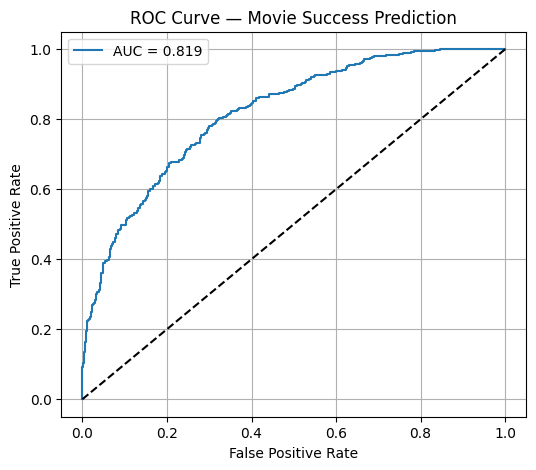

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch

model.eval()
with torch.no_grad():
    success_logit, _, _ = model(data)
    mask = data["movie"].test_mask

    probs = torch.sigmoid(success_logit[mask]).cpu().numpy()
    labels = data["movie"].y_success[mask].cpu().numpy()

fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Movie Success Prediction")
plt.legend()
plt.grid(True)
plt.show()
